<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utilities import *
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

from surprise import accuracy, Dataset, KNNBaseline, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import NMF,SVD

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)

# Section 3 MovieLens dataset

#### Q1 Report sparsity

In [4]:
n = len(ratings.movieId.unique())
m = len(ratings.userId.unique())
sparsity = np.divide(ratings.shape[0], n*m)
display(sparsity)

0.016439141608663475

#### Q2 plot histogram, showing freq of ratings

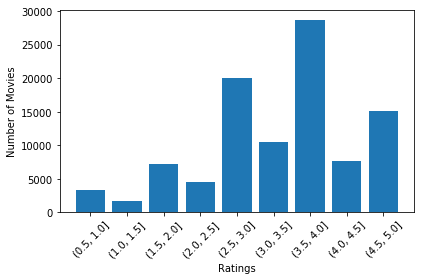

In [5]:
ratings['rating_bin'] = pd.cut(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5))
bar_height = ratings.groupby(['rating_bin']).agg({'rating': 'count'})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height['rating'])
ax.set_xticks(np.arange(bar_height.shape[0]))
ax.set_xticklabels(bar_height.index,rotation=45)
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Movies')

fig.tight_layout()
fig.savefig('report/figures/q2.png', dpi=300)

#### Q3 plot distribution of ratings among movies

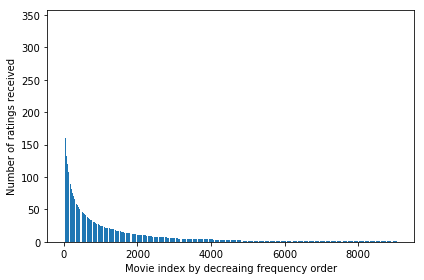

In [6]:
bar_height = ratings.groupby(['movieId']).agg({'rating': 'count'}).\
    rename(columns={'rating': 'rating_count'}).sort_values('rating_count', ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height.rating_count)
ax.set_xlabel('Movie index by decreaing frequency order')
ax.set_ylabel('Number of ratings received')

fig.tight_layout()
fig.savefig('report/figures/q3.png', dpi=300)

#### Q4 plot distribution of ratings among users

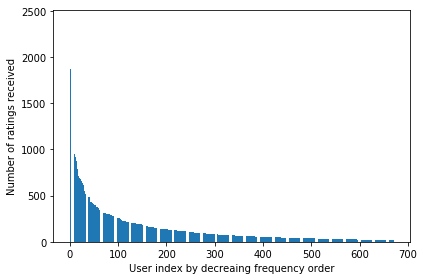

In [7]:
bar_height = ratings.groupby('userId').agg({'rating': 'count'}).\
    rename(columns={'rating': 'rating_count'}).sort_values('rating_count', ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height.rating_count)
ax.set_xlabel('User index by decreaing frequency order')
ax.set_ylabel('Number of ratings received')

fig.tight_layout()
fig.savefig('report/figures/q4.png', dpi=300)

#### Q6 compute the variance of ratings

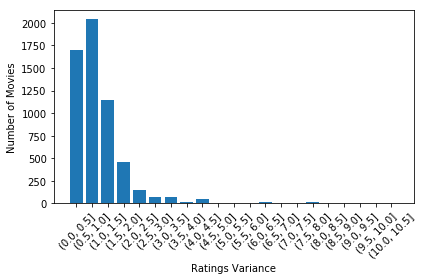

In [8]:
movie_var = ratings.groupby('movieId').agg({'rating': 'var'}).rename(columns={'rating': 'rating_var'}).reset_index()
movie_var['rating_var_bin'] = pd.cut(movie_var.rating_var, bins=np.arange(0, movie_var.rating_var.max()+0.5, 0.5))
bar_height = movie_var.groupby('rating_var_bin').agg({'rating_var': 'count'}).rename(columns={'rating_var': 'count'})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height['count'])
ax.set_xticks(np.arange(bar_height.shape[0]))
ax.set_xticklabels(bar_height.index,rotation=45)
ax.set_xlabel('Ratings Variance')
ax.set_ylabel('Number of Movies')

fig.tight_layout()
fig.savefig('report/figures/q6.png', dpi=300)

# Section 4 Neighborhood-based collaborative filtering

## Section 4.2 Pearson-correlation coefficient

#### Q7 write down the formula for $\mu_u$

$$\mu_u = \frac{1}{|I_u|}\sum_{k \in I_u} r_{uk}$$

#### Q8 explain $I_u \cap I_v$

Movies that have been both rated by user $u$ and user $v$. It could be an empty set.

## Section 4.5 $k$-NN collaborative filter

### Section 4.5.1 Design and test via cross-validation

#### Q10 design knn
Construct the rating matrix $R \in \textbf{R}^{n\times m}$, with assigning zero values to mean.

In [10]:
# method 1
str_time = time.time()

unique_movie = ratings.movieId.unique()
unique_users = ratings.userId.unique()
user_records = ratings.groupby(['userId'])
mean_ratings = user_records.agg({'rating': 'mean'})
ratin_matrix = mean_ratings.rating.values.reshape(len(unique_users), 1) + np.zeros(len(unique_movie))


print("--- %s seconds ---" % (time.time() - str_time))

--- 0.01911139488220215 seconds ---


In [11]:
pickle.dump(ratin_matrix, open('results/q10-rating_matrix', 'wb'))

In [12]:
# method 2
str_time = time.time()


unique_users = ratings.userId.unique()
user_records = ratings.groupby(['userId'])
mean_ratings = user_records.agg({'rating': 'mean'})
pearson_corr = np.zeros([len(unique_users)]*2)

for (u, v) in combinations(unique_users, 2):
#     mov_in_common = [movie for movie in user_records.get_group(u).movieId if movie in user_records.get_group(v).movieId]  # way too slow
#     r_u_bar = user_record.get_group(u).loc[moe_in_common, rating]
#     pearson_corr[u, v] = 
    pass

print("--- %s seconds ---" % (time.time() - str_time))

--- 0.017779827117919922 seconds ---


In [9]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
sim_options = {'name': 'pearson'}

mae_errors = []
rmse_error = []
ks = np.arange(2, 102, 2)

for k in ks:
    if k % 20 == 0:
        print(k)
    algo = KNNBaseline(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    mae_errors.append(results['test_mae'].mean())
    rmse_error.append(results['test_rmse'].mean())

Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similar

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matr

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matr

Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity ma

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing simi

Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarit

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson simila

In [10]:
min_k = np.max([np.argmax(mae_errors - np.min(mae_errors) <= 5e-3), np.argmax(rmse_error - np.min(rmse_error) <= 5e-3)])
ks[min_k]

18

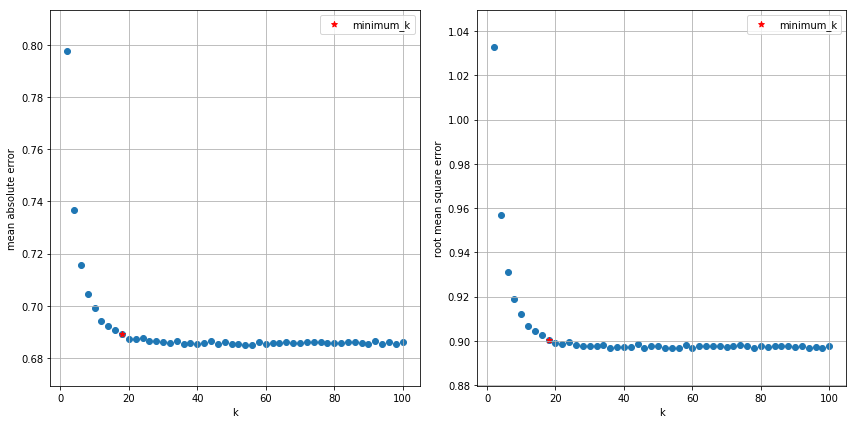

In [11]:
plot_mae_n_rmse(mae_errors, rmse_error, ks, min_k, 'q10.png')

#### Q11 find optimal $k$

In [12]:
display(min_k)
display(rmse_error[min_k])
display(mae_errors[min_k])

8

0.9002785239724854

0.689313781064805

## Section 4.6 Filter performance on trimmed test set

In [13]:
movie_rating_freq = ratings.groupby('movieId').agg({'userId': 'count'}).rename(columns={'userId': 'rating_count'})
movie_var = ratings.groupby('movieId').agg({'rating': lambda x: np.var(x)}).rename(columns={'rating': 'rating_var'})
popular_movies = movie_rating_freq[movie_rating_freq.rating_count > 2].index
unpplar_movies = movie_rating_freq[movie_rating_freq.rating_count < 3].index
highvar_movies = movie_rating_freq[np.logical_and(movie_rating_freq.rating_count > 5, movie_var.rating_var > 2)].index

In [14]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)
reader = Reader(rating_scale=(1, 5))
sim_options = {'name': 'pearson'}

popular_mae_errors = []
unpplar_mae_errors = []
highvar_mae_errors = []
popular_rmse_error = []
unpplar_rmse_error = []
highvar_rmse_error = []

ks = np.arange(2, 102, 2)

for k in ks:
    print(k)
    popular_mae_folds = []
    unpplar_mae_folds = []
    highvar_mae_folds = []
    popular_rmse_fold = []
    unpplar_rmse_fold = []
    highvar_rmse_fold = []
    
    algo = KNNBaseline(k=k, sim_options=sim_options)
    kfold = KFold(n_splits=10, shuffle=True, random_state=177)
    for trn_idx, tst_idx in kfold.split(ratings):
        trn = ratings.iloc[trn_idx, :]
        tst = ratings.iloc[tst_idx, :]
        popular_tst = tst[tst.movieId.isin(popular_movies)]
        unpplar_tst = tst[tst.movieId.isin(unpplar_movies)]
        highvar_tst = tst[tst.movieId.isin(highvar_movies)]
        
        trn_suprise = Dataset.load_from_df(trn[['userId', 'movieId', 'rating']], reader).build_full_trainset()
        popular_tst = Dataset.load_from_df(popular_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        unpplar_tst = Dataset.load_from_df(unpplar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        highvar_tst = Dataset.load_from_df(highvar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        
        algo.fit(trn_suprise)
        popular_results = algo.test(popular_tst, verbose=False)
        unpplar_results = algo.test(unpplar_tst, verbose=False)
        highvar_results = algo.test(highvar_tst, verbose=False)
        
        popular_mae_folds.append(accuracy.mae(popular_results, verbose=False))
        unpplar_mae_folds.append(accuracy.mae(unpplar_results, verbose=False))
        highvar_mae_folds.append(accuracy.mae(highvar_results, verbose=False))
        
        popular_rmse_fold.append(accuracy.rmse(popular_results, verbose=False))
        unpplar_rmse_fold.append(accuracy.rmse(unpplar_results, verbose=False))
        highvar_rmse_fold.append(accuracy.rmse(highvar_results, verbose=False))
    
    popular_mae_errors.append(np.mean(popular_mae_folds))
    unpplar_mae_errors.append(np.mean(unpplar_mae_folds))
    highvar_mae_errors.append(np.mean(highvar_mae_folds))
    popular_rmse_error.append(np.mean(popular_rmse_fold))
    unpplar_rmse_error.append(np.mean(unpplar_rmse_fold))
    highvar_rmse_error.append(np.mean(highvar_rmse_fold))

2
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using al

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
18
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
34
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
48
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
64
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
78
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
94
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

#### Q12 knn for popular set

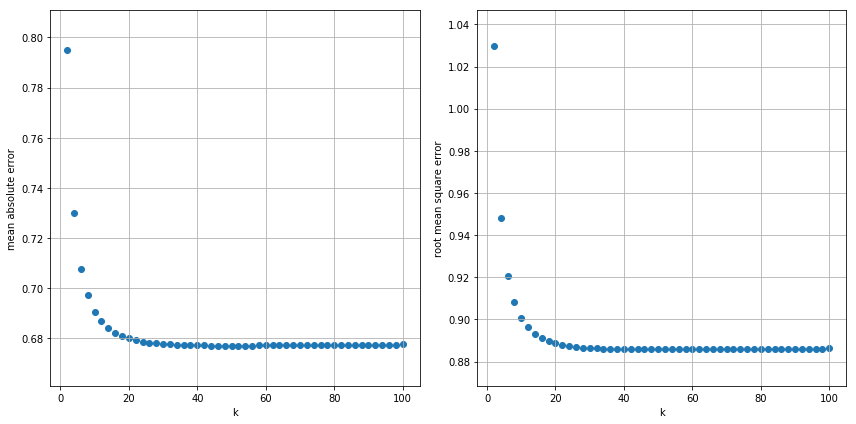

In [15]:
plot_mae_n_rmse(popular_mae_errors, popular_rmse_error, ks, None, 'q12.png')

#### Q13 knn for unpopular set

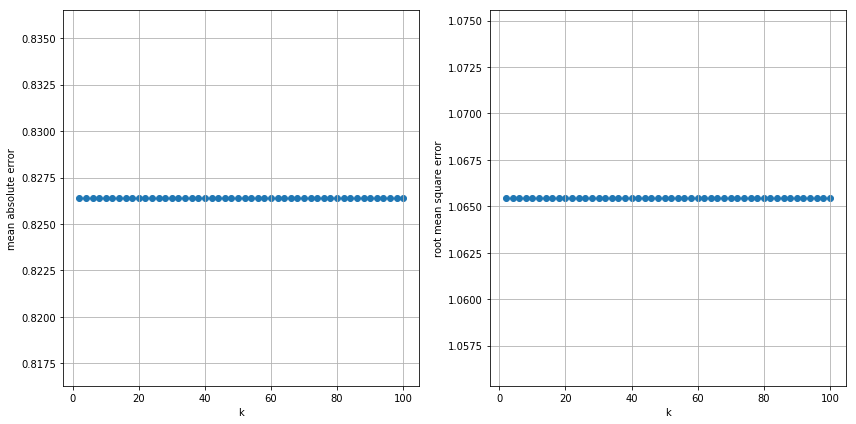

In [16]:
plot_mae_n_rmse(unpplar_mae_errors, unpplar_rmse_error, ks, None, 'q13.png')

#### Q14 knn for high variance set

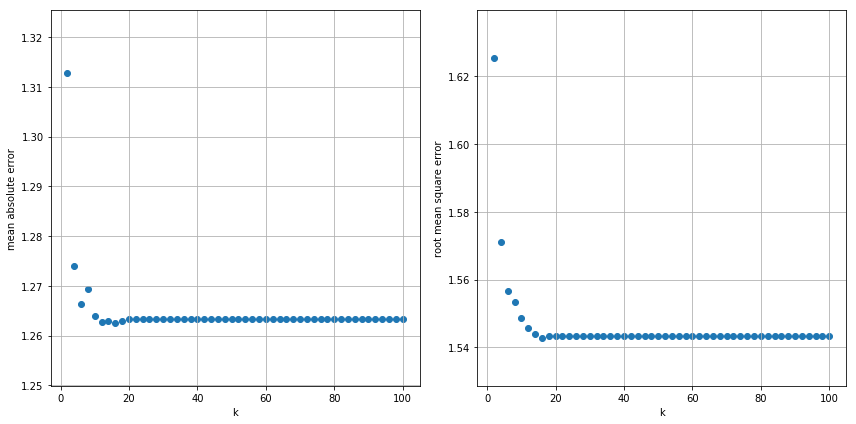

In [17]:
plot_mae_n_rmse(highvar_mae_errors, highvar_rmse_error, ks, None, 'q14.png')

### Section 4.6.1 Performance evaluation using ROC curve

#### Q15 plot ROC curve

In [18]:
trn, tst = train_test_split(data, test_size=0.1)
algo.fit(trn)
prediction = algo.test(tst, verbose=False)
y_true_pred = np.array([pred[2:4] for pred in prediction])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


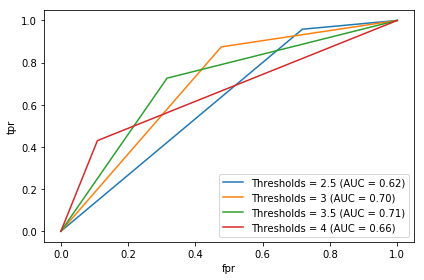

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
thresholds = [2.5, 3, 3.5, 4]

for threshold in thresholds:
    results = np.where(y_true_pred>=threshold, 1, 0)
    fpr, tpr, thresholds = roc_curve(results[:, 0], results[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='Thresholds = %s (AUC = %0.2f)' % (threshold, roc_auc))
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.legend()
    
fig.tight_layout()
fig.savefig('report/figures/q15.png', dpi=300)

In [ ]:
# save for Q34

In [ ]:
results = np.where(y_true_pred>3, 1, 0)
pickle.dump(results, open('results/' + 'q34-knn', 'wb'))

# Section 5 Model-based collaborative filtering

## Section 5.2 Nonnegative matrix factorization (NMF)

### Section 5.2.2 Design and test via cross-validation

#### Q17  design NMF

In [23]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)

mae_errors = []
rmse_errors = []
ks = np.arange(2, 50, 2)

for k in ks:
    if k % 10 == 0:
        print(k)
    alg = NMF(n_factors=k)
    results = cross_validate(alg, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    mae_errors.append(results['test_mae'].mean())
    rmse_errors.append(results['test_rmse'].mean())

10
20
30
40


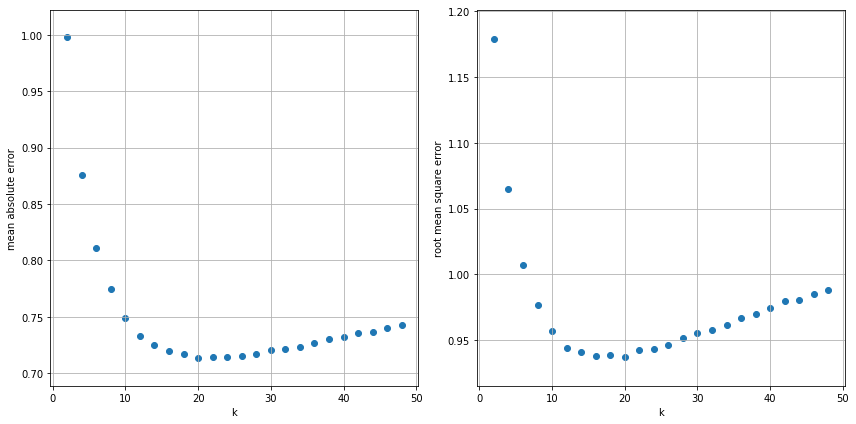

In [28]:
plot_mae_n_rmse(mae_errors, rmse_errors, ks, None, 'q17.png')

#### Q18 find optimal $k$

In [29]:
x = np.array(mae_errors)
y = np.array(rmse_errors)
sum_xy = x + y

print(x)
print(y)
print(sum_xy)
print(ks[x.argmin()])
print(ks[y.argmin()])
print(ks[sum_xy.argmin()])

[0.99785963 0.87609481 0.81065063 0.77488451 0.74930359 0.73269726
 0.7250117  0.71977685 0.71661807 0.7131162  0.71446373 0.71395131
 0.71533097 0.71671896 0.72037053 0.72115075 0.72333698 0.7269655
 0.72987957 0.73233096 0.7359091  0.73674901 0.73993654 0.74296685]
[1.17888744 1.06504216 1.00699124 0.97696652 0.95720574 0.94447571
 0.94127911 0.93816024 0.93905974 0.93758473 0.94273523 0.94330652
 0.94653983 0.95144975 0.95520496 0.95750934 0.96154534 0.96698376
 0.97008375 0.97480273 0.98005493 0.98073174 0.98479096 0.98854249]
[2.17674706 1.94113698 1.81764187 1.75185103 1.70650933 1.67717296
 1.66629081 1.65793709 1.65567781 1.65070093 1.65719896 1.65725784
 1.6618708  1.66816871 1.67557549 1.6786601  1.68488232 1.69394926
 1.69996332 1.70713369 1.71596403 1.71748075 1.7247275  1.73150934]
20
20
20


### Section 5.2.3 NMF filter performance on trimmed test set

In [30]:
popular_mae_errors = []
unpplar_mae_errors = []
highvar_mae_errors = []
popular_rmse_errors = []
unpplar_rmse_errors = []
highvar_rmse_errors = []

ks = np.arange(2, 50, 2)

for k in ks:
    print(k)
    popular_mae_folds = []
    unpplar_mae_folds = []
    highvar_mae_folds = []
    popular_rmse_fold = []
    unpplar_rmse_fold = []
    highvar_rmse_fold = []
    
    algo = NMF(n_factors=k)
    kfold = KFold(n_splits=10, shuffle=True, random_state=177)
    for trn_idx, tst_idx in kfold.split(ratings):
        trn = ratings.iloc[trn_idx, :]
        tst = ratings.iloc[tst_idx, :]
        popular_tst = tst[tst.movieId.isin(popular_movies)]
        unpplar_tst = tst[tst.movieId.isin(unpplar_movies)]
        highvar_tst = tst[tst.movieId.isin(highvar_movies)]
        
        trn_suprise = Dataset.load_from_df(trn[['userId', 'movieId', 'rating']], reader).build_full_trainset()
        popular_tst = Dataset.load_from_df(popular_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        unpplar_tst = Dataset.load_from_df(unpplar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        highvar_tst = Dataset.load_from_df(highvar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        
        algo.fit(trn_suprise)
        popular_results = algo.test(popular_tst, verbose=False)
        unpplar_results = algo.test(unpplar_tst, verbose=False)
        highvar_results = algo.test(highvar_tst, verbose=False)
        
        popular_mae_folds.append(accuracy.mae(popular_results, verbose=False))
        unpplar_mae_folds.append(accuracy.mae(unpplar_results, verbose=False))
        highvar_mae_folds.append(accuracy.mae(highvar_results, verbose=False))
        
        popular_rmse_fold.append(accuracy.rmse(popular_results, verbose=False))
        unpplar_rmse_fold.append(accuracy.rmse(unpplar_results, verbose=False))
        highvar_rmse_fold.append(accuracy.rmse(highvar_results, verbose=False))
    
    popular_mae_errors.append(np.mean(popular_mae_folds))
    unpplar_mae_errors.append(np.mean(unpplar_mae_folds))
    highvar_mae_errors.append(np.mean(highvar_mae_folds))
    popular_rmse_errors.append(np.mean(popular_rmse_fold))
    unpplar_rmse_errors.append(np.mean(unpplar_rmse_fold))
    highvar_rmse_errors.append(np.mean(highvar_rmse_fold))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48


#### Q19 NMF for popular set

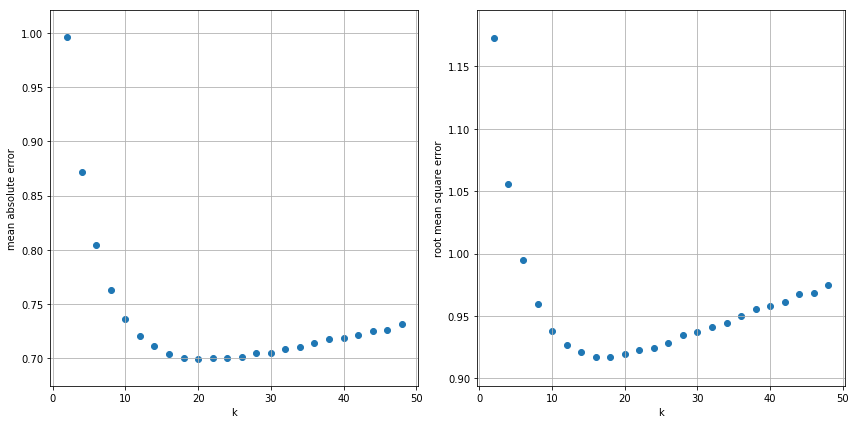

In [31]:
plot_mae_n_rmse(popular_mae_errors, popular_rmse_errors, ks, None, 'q19.png')

#### Q20 NMF for unpopular set

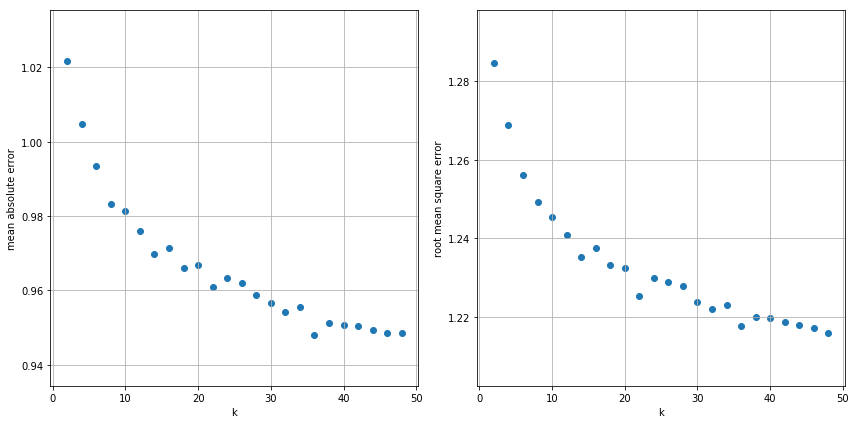

In [32]:
plot_mae_n_rmse(unpplar_mae_errors, unpplar_rmse_errors, ks, None, 'q20.png')

#### Q21 NMF for high variance set

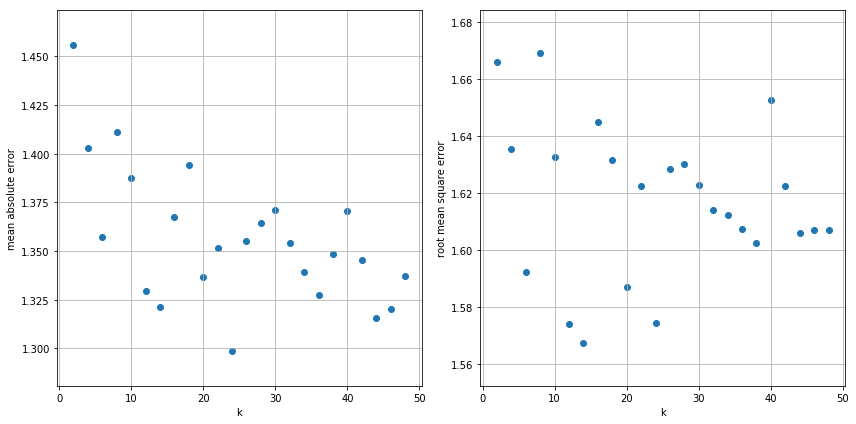

In [33]:
plot_mae_n_rmse(highvar_mae_errors, highvar_rmse_errors, ks, None, 'q21.png')

### Section 5.2.4 Performance evaluation using ROC curve

#### Q22 plot the ROC curve

In [34]:
trn, tst = train_test_split(data, test_size=0.1)
algo.fit(trn)
prediction = algo.test(tst, verbose=False)
y_true_pred = np.array([pred[2:4] for pred in prediction])

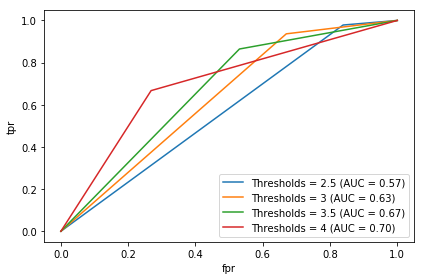

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
thresholds = [2.5, 3, 3.5, 4]

for threshold in thresholds:
    results = np.where(y_true_pred>=threshold, 1, 0)
    fpr, tpr, thresholds = roc_curve(results[:, 0], results[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='Thresholds = %s (AUC = %0.2f)' % (threshold, roc_auc))
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.legend()
    
fig.tight_layout()
fig.savefig('report/figures/q22.png', dpi=300)

### Section 5.2.5 Interpretability of NMF

#### Q23 connection between latent factors and movie genres

In [502]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)
reader = Reader(rating_scale=(1, 5))

full_data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader).build_full_trainset()
k = 20
    
algo = NMF(n_factors=k)
algo.fit(full_data)

#pu – The user factors (only exists if fit() has been called)
#qi – The item factors (only exists if fit() has been called)
#bu – The user biases (only exists if fit() has been called)
#bi – The item biases (only exists if fit() has been called)

movie_factor = np.array(algo.qi)
top_10 = []
for k in range(0,20):
    order = movie_factor[:,k].argsort()[::-1][:10]
    top_10.append(order)

movie_name = pd.read_csv('data/movies.csv')
movie_mapping = pd.DataFrame()
movie_mapping['movie_in_rating_order'] = ratings['movieId']
movie_mapping = movie_mapping['movie_in_rating_order'].drop_duplicates(keep='first')
movie_mapping = movie_mapping.reset_index()
movie_mapping = movie_mapping.drop('index',axis=1)

mapping = top_10[:20]
id_list = []
df = pd.DataFrame()
for i in mapping:
    df = movie_mapping.iloc[i]
    id_list.append(df['movie_in_rating_order'].values)
    #print(temp)
top10_genres = []
for movieID_list in id_list:
    top10_genres.append(movie_name['genres'].loc[  movie_name['movieId'].isin(movieID_list) ].values)
    #print(movie_name['genres'].loc[  movie_name['movieId'].isin(movieID_list) ].values)

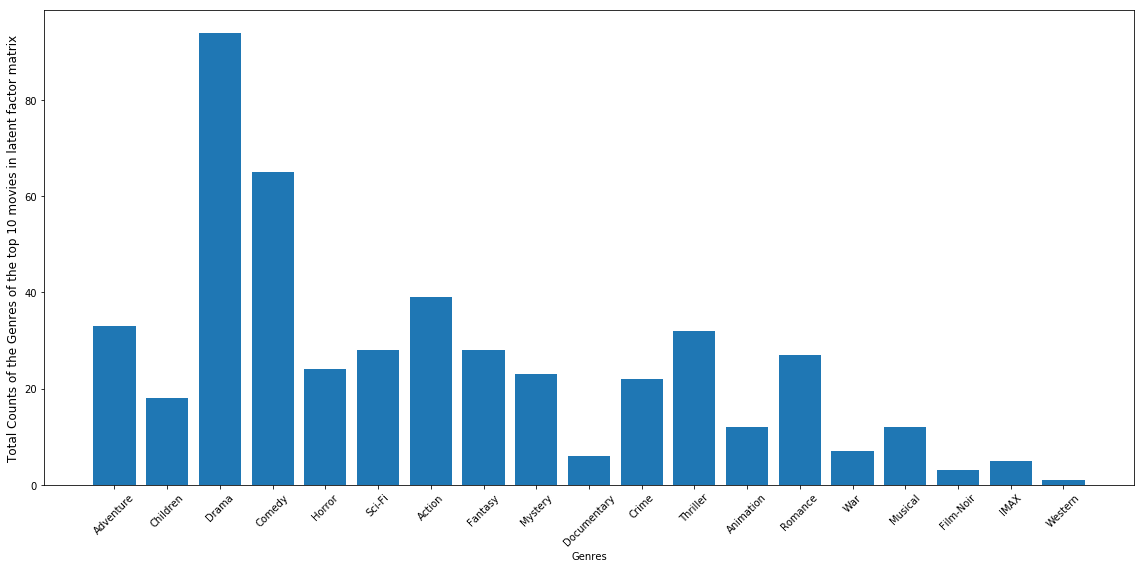

In [507]:
import collections as co
cnt_total = co.Counter()
for g in range(0,20):
    total_counts = []
    for x in top10_genres[g]:
        x = x.split('|')
        total_counts = np.append(total_counts,x)
    cnt = co.Counter()
    #print('=== k[{0}] ==='.format(g))
    for genre in total_counts:
        cnt[genre]+=1
    cnt_total.update(cnt)

labels, values = zip(*cnt_total.items())

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.bar(np.arange(len(labels)), values)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels,rotation=45)
ax.set_ylabel('Total Counts of the Genres of the top 10 movies in latent factor matrix',size=12)
ax.set_xlabel('Genres')

fig.tight_layout()
fig.savefig('report/figures/q23.png', dpi=300)


##### The combined counts of the genres of the top 10 movies in all columns of movie latent matrix shows that majority of them are of genres "Drama" and "Comedy. This could mean that "Drama" and "Comedy" type of movies are more influential in relation to user ratings.

In [505]:
import gc
gc.collect()

7800

## Section 5.3 Matrix factorization with bias

#### Q24 design and test via cross validation

In [30]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)

mae_errors = []
rmse_error = []
ks = np.arange(2, 102, 2)

for k in ks:
    if k % 20 == 0:
        print(k)
    algo = SVD(n_factors=k)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    mae_errors.append(results['test_mae'].mean())
    rmse_error.append(results['test_rmse'].mean())

20
40
60
80
100


In [31]:
min_k = np.max([np.argmax(mae_errors - np.min(mae_errors) <= 5e-3), np.argmax(rmse_error - np.min(rmse_error) <= 5e-3)])
ks[min_k]

2

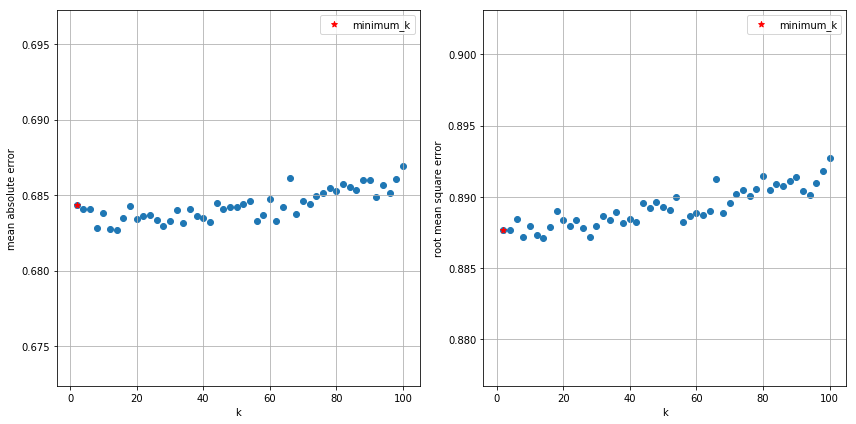

In [32]:
plot_mae_n_rmse(mae_errors, rmse_error, ks, min_k, 'q24.png')

#### Q25 find optimal k and display the corresponding MAE and RMSE

In [33]:
display(min_k)
display(rmse_error[min_k])
display(mae_errors[min_k])

0

0.8876402576398812

0.6843731732499332

### Section 5.3.3 MF with bias filter performance on trimmed test set|

In [19]:
movie_rating_freq = ratings.groupby('movieId').agg({'userId': 'count'}).rename(columns={'userId': 'rating_count'})
movie_var = ratings.groupby('movieId').agg({'rating': lambda x: np.var(x)}).rename(columns={'rating': 'rating_var'})
popular_movies = movie_rating_freq[movie_rating_freq.rating_count > 2].index
unpplar_movies = movie_rating_freq[movie_rating_freq.rating_count < 3].index
highvar_movies = movie_rating_freq[np.logical_and(movie_rating_freq.rating_count > 5, movie_var.rating_var > 2)].index

In [20]:
reader = Reader(rating_scale=(1, 5))
popular_mae_errors = []
unpplar_mae_errors = []
highvar_mae_errors = []
popular_rmse_error = []
unpplar_rmse_error = []
highvar_rmse_error = []

ks = np.arange(2, 102, 2)

for k in ks:
    print(k)
    popular_mae_folds = []
    unpplar_mae_folds = []
    highvar_mae_folds = []
    popular_rmse_fold = []
    unpplar_rmse_fold = []
    highvar_rmse_fold = []
    
    algo = SVD(n_factors=k)
    kfold = KFold(n_splits=10, shuffle=True, random_state=177)
    for trn_idx, tst_idx in kfold.split(ratings):
        trn = ratings.iloc[trn_idx, :]
        tst = ratings.iloc[tst_idx, :]
        popular_tst = tst[tst.movieId.isin(popular_movies)]
        unpplar_tst = tst[tst.movieId.isin(unpplar_movies)]
        highvar_tst = tst[tst.movieId.isin(highvar_movies)]
        
        trn_suprise = Dataset.load_from_df(trn[['userId', 'movieId', 'rating']], reader).build_full_trainset()
        popular_tst = Dataset.load_from_df(popular_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        unpplar_tst = Dataset.load_from_df(unpplar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        highvar_tst = Dataset.load_from_df(highvar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        
        algo.fit(trn_suprise)
        popular_results = algo.test(popular_tst, verbose=False)
        unpplar_results = algo.test(unpplar_tst, verbose=False)
        highvar_results = algo.test(highvar_tst, verbose=False)
        
        popular_mae_folds.append(accuracy.mae(popular_results, verbose=False))
        unpplar_mae_folds.append(accuracy.mae(unpplar_results, verbose=False))
        highvar_mae_folds.append(accuracy.mae(highvar_results, verbose=False))
        
        popular_rmse_fold.append(accuracy.rmse(popular_results, verbose=False))
        unpplar_rmse_fold.append(accuracy.rmse(unpplar_results, verbose=False))
        highvar_rmse_fold.append(accuracy.rmse(highvar_results, verbose=False))
    
    popular_mae_errors.append(np.mean(popular_mae_folds))
    unpplar_mae_errors.append(np.mean(unpplar_mae_folds))
    highvar_mae_errors.append(np.mean(highvar_mae_folds))
    popular_rmse_error.append(np.mean(popular_rmse_fold))
    unpplar_rmse_error.append(np.mean(unpplar_rmse_fold))
    highvar_rmse_error.append(np.mean(highvar_rmse_fold))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100


#### Q26 MF with bias for popular set

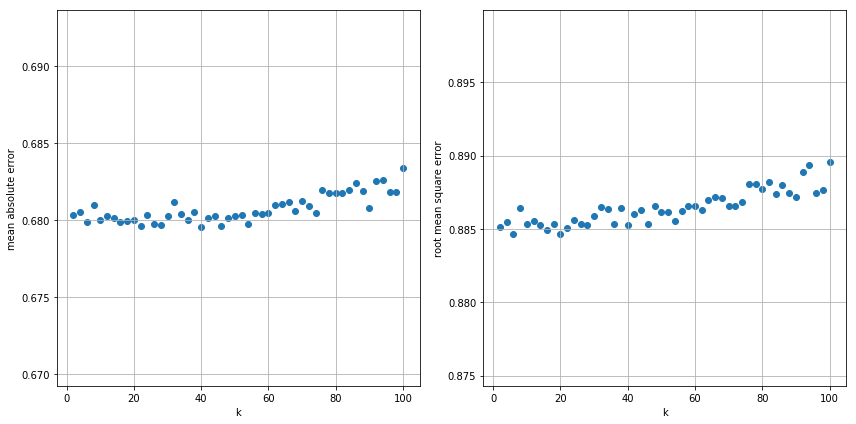

In [35]:
plot_mae_n_rmse(popular_mae_errors, popular_rmse_error, ks, None, 'q26.png')

#### Q27 MF with bias for unpopular set

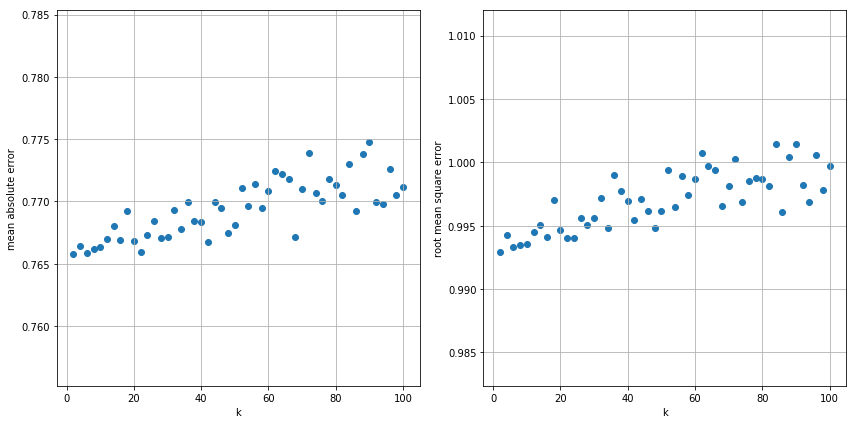

In [36]:
plot_mae_n_rmse(unpplar_mae_errors, unpplar_rmse_error, ks, None, 'q27.png')

#### Q28 MF with bias for high variance set

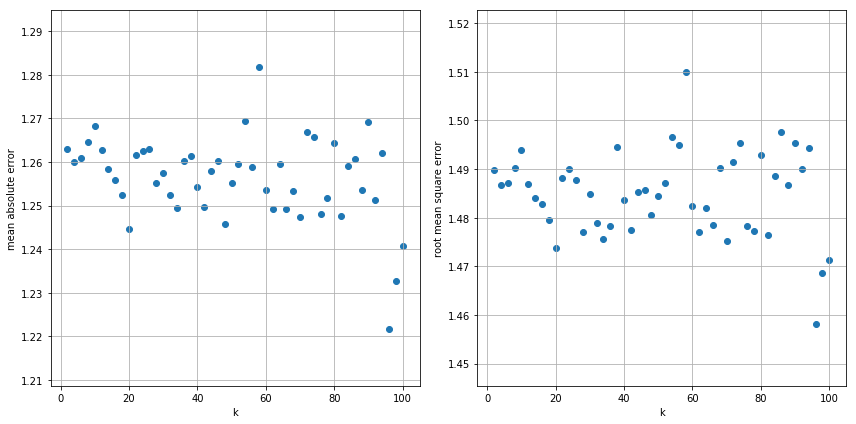

In [37]:
plot_mae_n_rmse(highvar_mae_errors, highvar_rmse_error, ks, None, 'q28.png')

### Section 5.3.4 Performance evaluation using ROC curve

####  Q29 plot the ROC curve

In [38]:
trn, tst = train_test_split(data, test_size=0.1)
algo.fit(trn)
prediction = algo.test(tst, verbose=False)
y_true_pred = np.array([pred[2:4] for pred in prediction])

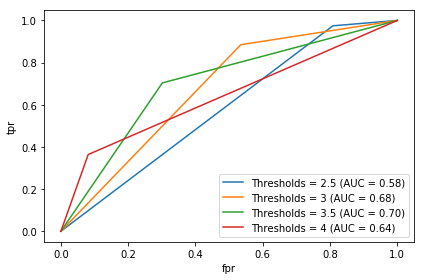

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
thresholds = [2.5, 3, 3.5, 4]

for threshold in thresholds:
    results = np.where(y_true_pred>=threshold, 1, 0)
    fpr, tpr, thresholds = roc_curve(results[:, 0], results[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='Thresholds = %s (AUC = %0.2f)' % (threshold, roc_auc))
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.legend()
    
fig.tight_layout()
fig.savefig('report/figures/q29.png', dpi=300)

# Section 6 Naive collaborative filtering

## Q30 - Q33

# Section 7 Performance comparison

#### Q34 plot the ROC curve

# Section 8 Ranking

## Q35

## Q36

In [ ]:
n_splits = 10
threshold = 3
ts = np.arange(1, 26, 1).tolist()
scoring = np.zeros([n_splits, len(ts)*2])
args = ts + [threshold]

reader = Reader(rating_scale=(1, 5))
sim_options = {'name': 'pearson'}
algo = KNNBaseline(k=18, sim_options=sim_options)
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=177)

for i, (trn_idx, tst_idx) in enumerate(kfold.split(ratings)):
    trn = ratings.iloc[trn_idx, :]
    tst = ratings.iloc[tst_idx, :]
    
    trn_surprise = Dataset.load_from_df(trn[['userId', 'movieId', 'rating']], reader).build_full_trainset()
    tst_surprise = Dataset.load_from_df(tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()

    algo.fit(trn_surprise)
    prediction = algo.test(tst_surprise, verbose=False)
    
    grouped_tst = build_tst(tst, prediction)
    results = grouped_tst.apply(compute_ppv_tpr, *args)
    
    scoring_folds = []
    for j in range(50):
        scoring_folds.append(results.apply(lambda x: x[j]).mean(skipna=True))
    scoring[i, :] = scoring_folds
scoring = scoring.mean(axis=0).reshape(2, len(ts))

In [ ]:
pickle.dump(results, open('results/' + 'q36-knn', 'wb'))

## Q37

## Q38

## Q39